<a href="https://colab.research.google.com/github/ATKhakimov/QML/blob/main/Transfer_bunnies%26rabbits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import os
import copy


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms


!pip install pennylane
!pip install unrar 
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)


!pip install mplcyberpunk
import matplotlib.pyplot as plt
import mplcyberpunk



# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 
     |████████████████████████████████| 15.3 MB 30.9 MB/s 
     |████████████████████████████████| 145 kB 54.6 MB/s 
     |████████████████████████████████| 1.9 MB 39.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Новый раздел

In [ ]:
!unrar x "{/content/hymenoptera_data.zip}"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal

Cannot open {/content/hymenoptera_data.zip}
No such file or directory
No files to extract


импортируем либки

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 5              # Number of samples for each training step
num_epochs = 30              # Number of training epochs
q_depth = 15                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
data_transforms = {
    "train": transforms.Compose(
        [
        
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/drive/MyDrive/dataset1"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

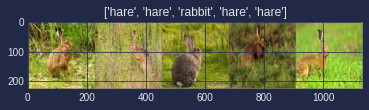

In [ ]:

inputs, classes = next(iter(dataloaders["validation"]))


out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
def RX_layer(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)
def RZ_layer(w):
    """Layer of parametrized qubit rotations around the z axis.
    """
    for idx, element in enumerate(w):
        qml.RZ(element, wires=idx)

def new_entangling_layer(nqubits):
    for i in range(0, nqubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[nqubits-1,0])

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    H_layer(n_qubits)
    RY_layer(q_input_features)
    for k in range(q_depth):
        RY_layer(q_weights[k])
        RX_layer(q_weights[k])
        RY_layer(q_weights[k])
        new_entangling_layer(n_qubits)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):

        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.post_net(q_out)

In [ ]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

model_hybrid.fc = DressedQuantumNet()

model_hybrid = model_hybrid.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)


In [ ]:
import numpy as np
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0 
    best_acc_train = 0.0
    best_loss_train = 10000.0  
    x = np.arange(1, num_epochs + 1)
    y = np.array([])
    y1 = np.array([])
    y_loss_train = np.array([])
    y_loss_val = np.array([])
    print("Training started:")

    for epoch in range(num_epochs):
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )
            if phase == "train":
              y1 = np.append(y1, epoch_acc)
              y_loss_train = np.append(y_loss_train, epoch_loss)
            else:
              y = np.append(y, epoch_acc)
              y_loss_val = np.append(y_loss_val, epoch_loss)

            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            if phase == "train":
                scheduler.step()

    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    plt.xlabel('Epoch', fontsize=15, color='white')
    plt.ylabel('Accuracy and losses', fontsize=15, color='white')
    dx = 1
    plt.plot(x,y, label = 'acc_val')
    plt.plot(x, y1, label = 'acc_train')
    plt.plot(x,y_loss_val, label = 'loss_val')
    plt.plot(x, y_loss_train, label = 'loss_train')
    plt.legend()
    return model

Training started:
Phase: train Epoch: 1/30 Loss: 0.6995 Acc: 0.4551        
Phase: validation   Epoch: 1/30 Loss: 0.6816 Acc: 0.4265        
Phase: train Epoch: 2/30 Loss: 0.6455 Acc: 0.6780        
Phase: validation   Epoch: 2/30 Loss: 0.5606 Acc: 0.8673        
Phase: train Epoch: 3/30 Loss: 0.5273 Acc: 0.7988        
Phase: validation   Epoch: 3/30 Loss: 0.4529 Acc: 0.8531        
Phase: train Epoch: 4/30 Loss: 0.4421 Acc: 0.8514        
Phase: validation   Epoch: 4/30 Loss: 0.3663 Acc: 0.9100        
Phase: train Epoch: 5/30 Loss: 0.3717 Acc: 0.8793        
Phase: validation   Epoch: 5/30 Loss: 0.3266 Acc: 0.9147        
Phase: train Epoch: 6/30 Loss: 0.3877 Acc: 0.8452        
Phase: validation   Epoch: 6/30 Loss: 0.3397 Acc: 0.9005        
Phase: train Epoch: 7/30 Loss: 0.3653 Acc: 0.8700        
Phase: validation   Epoch: 7/30 Loss: 0.2739 Acc: 0.9336        
Phase: train Epoch: 8/30 Loss: 0.3665 Acc: 0.8731        
Phase: validation   Epoch: 8/30 Loss: 0.2888 Acc: 0.9100       

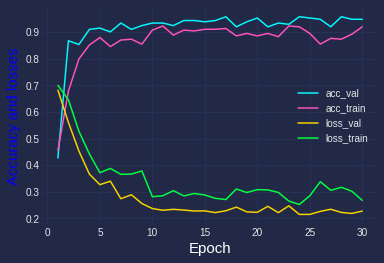

In [ ]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

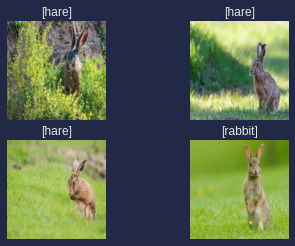

In [ ]:
visualize_model(model_hybrid, num_images=4)
plt.show()

In [ ]:
!pip install pylatexenc
import pylatexenc
!pip install qiskit
import matplotlib
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit import Parameter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 4.7 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=fbea990ce862a465685f16f0d9e570ddfef1278b5b0ff8ec75503f8e49f56a8f
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 6.8 MB/s 
     |████████████████████████████████| 19.2 MB 316 kB/s 
     |████████████████████████████████| 240 kB 56.9 MB/s 
     |████████████████████████████████| 106 kB 55.4 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 943 kB 44

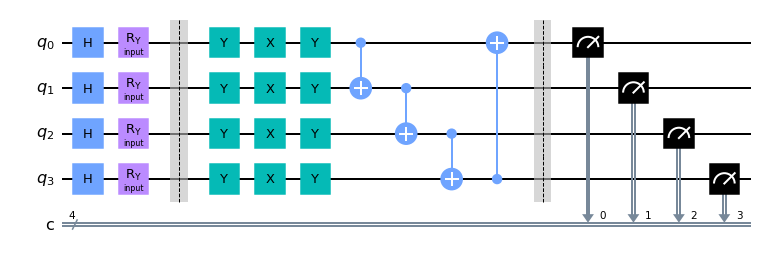

In [ ]:
x1 = Parameter('input')
x2 = Parameter('x2')
circuit = QuantumCircuit(4, 4)
circuit.h(range(4))
circuit.ry(x1, range(4))
circuit.barrier()
circuit.y(range(4))
circuit.x(range(4))
circuit.y(range(4))

circuit.cnot(0, 1)
circuit.cnot(1, 2)
circuit.cnot(2, 3)
circuit.cnot(3, 0)
circuit.barrier()

#circuit.measure(1, 1)
circuit.measure(range(4), range(4))
circuit.draw('mpl')